<div align="center">
    <h2>Reinforcement Learning Summer 2024</h2>
    <h2>Prof. Dr. Frank Kirchner</h2>
    <h4>Exercise Sheet – III</h4>
    <h5>Due: 22.05.24</h5>
    <hr>
</div>


**Problem 3.1: Eligibility Traces (10 P.)**

Using the information from a reward solely to update one state does not seem efficient when we could have updated the states in the path as well. Eligibility Traces (ET) do exactly that. This task is for exploring ET and visualizing the results from using different versions of ET. For that you will use the provided custom grid world.  



<p style="text-align:center;">
<img src="grid_world.png" alt="Your Image" width="400">
</p>

**Hand in the final code of the whole exercise and also the plotted curves for all subtasks.**

1. **(1 P.)** Make yourself familiar with the environment. E.g. The observation- and action-spaces, reward, returns, etc.
2. **(4 P.)** Implement both SARSA($\lambda$) and WatkinsQ($\lambda$) with the option to choose between the methods. Use an e-greedy implementation with $\epsilon = e^{-i/\text{max}(i)}$ where $i$ is the number of the current episode. Choose a good $\alpha$ and $\lambda$.
3. **(1 P.)** Add also the option to switch between replacing and accumulating traces. Run a test with 100 episodes for each version and plot the cumulative rewards.
4. **(2 P.)** Implement the option to print out a path (use the parameter *path* in the render functions). Path should be a list consisting of 3-tuples with the coordinates and the increase in the q-value of the taken actions. Use small circles to mark the path with their size indicating the increase.
5. **(2 P.)** Test the previous implementation with a TD($\lambda$) control method of your choice. Visualize the traces every ten percent of the total episodes. Run this until the agent does not run into walls anymore. Thus, find a good number of training episodes. In the end plot the cumulative reward and mark the cumulative reward with the iteration when each of the depicted trajectories started.


### Defining environment

In [5]:
import gymnasium as gym
from gymnasium import spaces
import pygame
import numpy as np
from gymnasium.envs.registration import register
import warnings

# Filter warnings specifically from gymnasium's core.py module
warnings.filterwarnings("ignore", category=UserWarning, module="gymnasium.core")


class GridWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array", "traces"], "render_fps": 0.5}

    def __init__(self, render_mode=None, seed=42):
        self._render = False
        self.path = []
        super().reset(seed=seed)
        self.size = 7  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, self.size - 1, shape=(2,), dtype=int),
                "target": spaces.Box(0, self.size - 1, shape=(2,), dtype=int),
                "walls": spaces.MultiBinary([self.size, self.size])
            }
        )

        # We have 4 actions, corresponding to "right", "up", "left", "down"
        self.action_space = spaces.Discrete(4)

        # Use fixed target location
        self._target_location = self.np_random.integers([self.size // 2 + 1, 0], [self.size - 1, self.size - 1], 2, dtype=int)
       
        # Create the wall, leave out a gab in the center
        self._walls_location = np.zeros((self.size, self.size), dtype=np.int32)
        self._walls_location[self.size // 2] = 1
        self._walls_location[self.size // 2, self.size // 2] = 0

        """
        The following dictionary maps abstract actions from `self.action_space` to
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: np.array([1, 0]),
            1: np.array([0, 1]),
            2: np.array([-1, 0]),
            3: np.array([0, -1]),
        }

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None

    def _get_obs(self):
        return {"agent": self._agent_location, "target": self._target_location, "walls": self._walls_location}
        
    def _get_info(self):
        return {
            "distance": np.linalg.norm(
                self._agent_location - self._target_location, ord=1
            )
        }
        
    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)
    
        # Choose the agent's location uniformly at random
        self._agent_location = self.np_random.integers([0, 0], [self.size // 2 - 1, self.size - 1], 2, dtype=int)

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info
    
    def step(self, action):
        reward = 0
        # Map the action (element of {0,1,2,3}) to the direction we walk in
        direction = self._action_to_direction[action]
        # We use `np.clip` to make sure we don't leave the grid

        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )

        # Test if agent hit a wall -> Negative reward
        if self._walls_location[tuple(self._agent_location)] == 1:
            self._agent_location -= direction
            reward = -0.5

        # An episode is done iff the agent has reached the target
        terminated = np.array_equal(self._agent_location, self._target_location)
        reward = 1 if terminated else reward  
        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human" or self._render:
            self._render_frame(reward=reward)

        return observation, reward, terminated, False, info
    
    # support funcions to get around the strict environment specifications
    def set_render(self, render):
        self._render = render 

    def render_path(self, path):
        self._render_frame(path)

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()
        elif self.render_mode == "traces":
            self._render_frame()

    def _render_frame(self, path=[], reward=0):
        if self.window is None and self.render_mode in ["human", "traces"]:
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode(
                (self.window_size, self.window_size)
            )
        if self.clock is None and self.render_mode in ["human", "traces"]:
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # First we draw the target
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location,
                (pix_square_size, pix_square_size),
            ),
        )
        # Now we draw the agent
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Draw walls 
        # added visualization of reaching the goal (green) and hitting a wall (red)
        if reward == 1:
            rgb = (0, 255, 0)
        elif reward == -0.5:
            rgb = (255, 0, 0)
        else:
            rgb =(0, 0, 0)

        for i in range(self.size):
            for j in range(self.size):
                if self._walls_location[i,j] == 1:
                    pygame.draw.rect(
                        canvas,
                        rgb,
                        [pix_square_size * i, pix_square_size * j, pix_square_size, pix_square_size]
                        )


        # draw path if it is not empty
        if path:
            # get max delta
            dq_max = max(path[2::3])
            dq_min = min(path[2::3])
            for i in range(len(path) // 3):
                # get three tuples 
                x, y, dq = path[i*3:i*3+3]
                # only plot legit dqs
                if dq > 0:
                    pygame.draw.circle(
                    canvas,
                    (0, 200, 0),
                    ((x + 0.5) * pix_square_size, (y + 0.5) * pix_square_size),
                    dq / dq_max * pix_square_size / 3,
                    )
                elif dq < 0:
                    pygame.draw.circle(
                    canvas,
                    (200, 0, 0),
                    ((x + 0.5) * pix_square_size, (y + 0.5) * pix_square_size),
                    dq / dq_min * pix_square_size / 3,
                    )


        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode in ["human", "traces"]:
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )
        
    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()


### 3.1a: Eligiblity traces intialisation

In [2]:
import numpy as np
import sys
from matplotlib import pyplot as plt

class ETLearning:

    def __init__(self, env):
        self.env = env
        self.size = tuple(env.observation_space["agent"].high - env.observation_space["agent"].low + 1)
        self.rng = np.random.default_rng()

    def e_greedy(self, state, epsilon):
        if self.rng.random() < epsilon:
            return self.env.action_space.sample()
        else:
            # if there are multiple actions with the same q_value choose random between them
            actions = np.where(self.q_values[state[0], state[1], :] == self.q_values[state[0], state[1],:].max())[0]
            return actions[0] if len(actions) == 1 else self.rng.choice(actions)
                       
    
    def learning(self, episodes, update_rule='SARSA', traces = "acc", render=False, alpha=0.5, gamma=0.9, lambda_=0.9 ):
        self.q_values = np.zeros((self.size[0], self.size[1], self.env.action_space.n))
        self.reward = [0]
        self.trajs = []

        if update_rule not in ['SARSA', 'WatkinsQ']:
            sys.exit('Unknown update_rule, use either \'SARSA\' or \'WatkinsQ\' !')
        
        for i in range(episodes):
            # initialize episode
            epsilon = np.exp(- i / episodes)
            e_traces = np.zeros_like(self.q_values)
            s_t = self.env.reset()[0]["agent"]
            a_t = self.e_greedy(s_t, epsilon)
            
            # save trajectory 
            path = []

            # render last episode
            if render and i == episodes - 1:
                self.env.set_render(True)

            while(True):
                obs, r, terminate, truncated, _ = self.env.step(a_t)
                s_prime = obs["agent"]
                
                # track metrics
                self.reward.append(self.reward[-1] + r)              
                path += [(s_t[0], s_t[1], a_t)]

                a_prime = self.e_greedy(s_prime, epsilon)
                a_star = np.argmax(self.q_values[s_prime[0], s_prime[1], :]) # for watkinsq

                # in case of SARSA a_star is the a_prime from the pseudocode
                if  update_rule == "SARSA" or \
                    self.q_values[s_prime[0], s_prime[1], a_prime] == self.q_values[s_prime[0], s_prime[1], a_star]:
                    a_star = a_prime

                # can be used for both update rules
                delta = r + gamma * self.q_values[s_prime[0], s_prime[1], a_star] - self.q_values[s_t[0], s_t[1], a_t]
                

                # update traces
                if traces == "acc":
                    # accumulate
                    tmp = e_traces[s_t[0], s_t[1], a_t] + 1
                else:
                    # replace
                    tmp = 1
                    # update other action traces of the current state to 0
                    e_traces[s_t[0], s_t[1], :] = 0
                
                # set current state trace
                e_traces[s_t[0], s_t[1], a_t] = tmp

                # update state action values and traces
                self.q_values += alpha * delta * e_traces
                if update_rule == "SARSA" or a_prime == a_star:
                    e_traces *= gamma * lambda_
                else:
                    e_traces *= 0

                if terminate or truncated:
                    break
                else:
                    s_t = s_prime
                    a_t = a_star

            # add the elegibility traces to the path
            traj = []
            for x, y, a in path:
                traj += [x, y, e_traces[x,y,a]]
            self.trajs.append(traj)

            if render and i % (episodes // 10) == 0:
                # marker for plotted trajectories
                self.trajs.append(-1)
                self.env.render_path(traj)

        return self.q_values, self.reward, self.trajs


### 3.2b: Run eligiblity traces

Seed:  27
Start learning...
1. Done
2. Done
3. Done
4. Done


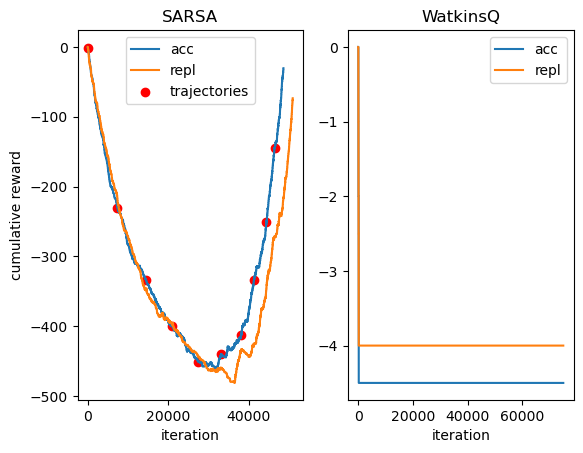

In [7]:
#import grid_env
import numpy as np
import gymnasium as gym
from matplotlib import pyplot as plt

#from EligTraces import ETLearning

# for different positions
seed = np.random.randint(42)
print("Seed: ", seed)
env = GridWorldEnv( render_mode="traces", seed=seed) # seed = 17
# prevent infinite loops
env = gym.wrappers.TimeLimit(env, max_episode_steps=50)

learner = ETLearning(env)
print("Start learning...")
# train different models
_, reward_2, _ = learner.learning(1500, update_rule="SARSA", traces="repl", alpha=0.25, lambda_=0.8, render = False)
print("1. Done")
_, reward_3, _ = learner.learning(1500, update_rule="WatkinsQ", traces="acc", alpha=0.25, lambda_=0.8, render = False)
print("2. Done")
_, reward_4, _ = learner.learning(1500, update_rule="WatkinsQ", traces="repl", alpha=0.25, lambda_=0.8, render = False)
print("3. Done")
_, reward_1, trajectories = learner.learning(1500, update_rule="SARSA", traces="acc", alpha=0.25, lambda_=0.8, render = True)
print("4. Done")

env.close()

# mark trajectory rewards
i = 0
x_traj = []
y_traj = []
for t in trajectories:
    if t == -1:
        x_traj.append(i)
        y_traj.append(reward_1[i])
    else:
        i += len(t) // 3

fig, axes = plt.subplots(1, 2)
axes[0].plot(reward_1, label="acc")
axes[0].plot(reward_2, label="repl")
axes[0].scatter(x_traj, y_traj, label="trajectories", c="r")
axes[1].plot(reward_3, label="acc")
axes[1].plot(reward_4, label="repl")

axes[0].set(title="SARSA", xlabel="iteration", ylabel="cumulative reward")
axes[1].set(title="WatkinsQ", xlabel="iteration")
axes[0].legend()
axes[1].legend()
plt.show()

**Problem 3.2: Model-based Reinforcement Learning (10 P.)**

In the last sheet we used Q-Learning and SARSA to find the optimal way to navigate the frozen lake environment. However, the 8x8 version of the environment took much longer than the 4x4 one. Reasons for this were:

- Constant epsilon value
- Reward only when transitioning to the goal state
- Update of values only based on the previous values
- "Back and forth" during exploration

For this task we want to improve the results a lot by using the model-based approaches from the lecture.

**Hand in the final code of the whole exercise and also the plotted curves for all subtasks.**

1. **(3 P.)** Start by implementing the plain DynaQ-Algorithm. The function should return the final Q-values as well as a list with the cumulative reward for each iteration. Test your implementation with these parameter values:
    - $epsilon = 0.5$ (you can also try out other values for epsilon)
    - $gamma = 0.9$, $alpha= 0.1$, $N = 10$ (Planning index)
    - Initial Q-values $init\_value = 0.0$ and 
    - Iterations = 200000
    When plotting the results with the provided function you most probably will observe that all the Q-values are still zero. Change the constant value for epsilon to the dynamic $\epsilon = e^{-i/\text{max}(i)}$ where i is the current number of iterations. You might need to run this a few times until you see a result but it should find the goal. Since reaching the goal is not guaranteed and the number of iterations is enormous you are going to improve the algorithm to enhance the results.
2. **(3 P.)** The rewards here are sparse and the environment is deterministic, therefore add Prioritized Sweeping to the implementation  (use the theta parameter in the function call). You do not need to implement a complex priority queue. Two lists are sufficient. Also, the defaultdict might help you with step 7 d). Test this with the parameters $gamma = 0.9$, $alpha = 0.5$, $N = 10$ (maximum planning iterations) and $theta = 0.01$. What do you observe?
3. **(2 P.)** Try now to add a negative reward every time the agent falls into an ice hole. Implement a [custom wrapper](https://gymnasium.farama.org/tutorials/gymnasium_basics/implementing_custom_wrappers/) from the gymnasium framework that adds a settable negative reward r_hole when the agent falls into an ice hole. Test this with r_hole values of [0, -0.01, -0.05, -0.1, -0.5, -1, -2] and the same parameters as before, recording the cumulative rewards for the episodes. Plot the curves for the rewards.
4. **(2 P.)** At last, incorporate the idea of balanced wandering into the $\epsilon$-greedy policy. Right now, exploration means choosing a random action. Your version should instead choose the action that was chosen the least so far when the state is unknown (in the sense of the the $E^3$-Algorithm). Also test this with different values and parameters of your choice. Hand in the plot of the parameter combination with the best result using the provided plotting function.

*Optional:* Try out different frozen lake maps by using the random map generator:

```python
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
gym.make('FrozenLake-v1', desc=generate_random_map(size=8, seed=5))


### 3.2a: Initialising Model based RL

In [8]:
# You do not need to use the already imported modules, but they might help you
import numpy as np
import random
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt

# Implementation of the DynaQ-Algorithm with the option of priorized sweeping and balanced wandering
class MBLearner:

    # safe the size and env for later
    def __init__(self, env, size = (8,8)):
        self.env = env
        self.size = size
        self.rng = np.random.default_rng()

    def e_greedy(self, state, epsilon, wander):
        """
        Function which uses the e-greedy method to choose an action. Optional: Balanced wandering 

        state -> int
        epsilon -> float
        wander -> int
        """

        # exploration
        if self.rng.random() < epsilon :
            # balanced wandering
            # when all the actions have been taken sufficiently often,
            if all(self.actions_taken[state, :] >= wander) :
                return self.env.action_space.sample()
            else:
                # choose action which has been taken the least so far, if there are multiple ones choose on of them
                actions = np.where(self.actions_taken.sum(axis=0) == self.actions_taken.sum(axis=0).min())[0]
                return actions[0] if len(actions) == 1 else self.rng.choice(actions)

        # exploitation          
        else:
            # if there are multiple actions with the same q_value choose random between them
            actions = np.where(self.q_values[state,:] == self.q_values[state,:].max())[0]
            return actions[0] if len(actions) == 1 else self.rng.choice(actions)
                       

    # takes care of step 7 d) of the prioritized sweeping
    def insert_to_pq(self, state, gamma, theta):
        for a,s in self.rev_model[state].items():
            s_prime, r = self.model[(s,a)]
            assert s_prime == state

            priority = abs(r + gamma * self.q_values[s_prime,:].max() - self.q_values[s, a])
            if priority > theta:
                self.p_list.append(priority)
                self.q_list.append((s,a))

    def learning(self, iterations, N, balanced_wandering=0, theta = 0.1, alpha = 0.5, gamma = 0.9):
        
        # cumulative reward
        self.reward = [0]

        # initialization
        self.q_values = np.zeros((self.size[0] * self.size[1], self.env.action_space.n))
        self.model = {}
        # add the reverse way for prioritized sweeping
        self.rev_model = defaultdict(dict)
       
        # for the prioritized sweeping
        self.p_list = [] # keeps the priorities
        self.q_list = [] # keeps the state-action tuples

        # action counter for the balanced wandering
        self.actions_taken = np.zeros((self.env.observation_space.n, self.env.action_space.n))

        # start env
        s_t, _ = self.env.reset()

        # do forever (iterate over states/steps not episodes)
        for i in range(iterations):

            # choose action with dynamic epsilon
            a_t = self.e_greedy(s_t, np.exp(-i / iterations), balanced_wandering)
            
            # increase the action counter
            self.actions_taken[s_t, a_t] += 1

            s_t1, r_t1, terminated, truncated, _ = self.env.step(a_t)

            # increase cumulative reward
            self.reward.append(self.reward[-1] + r_t1)
            
            # add experience to model (since it is deterministic, overwritten values should be the same as the new ones)
            self.model[(s_t, a_t)] = (s_t1, r_t1)
            
            # add the reverse way from s_t1 to s_t
            # this makes heavy use of the defaultdicts feature to create and fill entries at the same time without the need to check
            # you can play around with the following few lines if this is interesting for you
            # from collections import defaultdict
            # test = defaultdict(dict)
            # test["a"]["a"] = 5
            # test["a"]["a"] = 6
            # test["a"]["b"] = 6
            # test["b"]["b"] = 6
            # print(test)
            self.rev_model[s_t1][a_t] = s_t
            
            if theta is None:
                # no prioritized sweeping
                self.q_values[s_t, a_t] += alpha * (r_t1 + gamma * self.q_values[s_t1,:].max() - self.q_values[s_t, a_t])
            else:
                priority = abs(r_t1 + gamma * self.q_values[s_t1,:].max() - self.q_values[s_t, a_t])
                if priority > theta:
                   self.p_list.append(priority)
                   self.q_list.append((s_t,a_t))
            
            # Planning, 
            for _ in range(N):
                if theta is None:
                    # no prioritized sweeping
                    (s_tilde, a_tilde), (s_prime, r_tilde) = random.choice(list(self.model.items()))
                    self.q_values[s_tilde, a_tilde] += alpha * (r_tilde + gamma * self.q_values[s_prime,:].max() - self.q_values[s_tilde, a_tilde])
                
                # break if priority queue is empty
                elif not(self.p_list):
                    break
                else:
                    # Prioritized Sweeping
                    idx = np.argmax(self.p_list)
                    s_tilde, a_tilde = self.q_list[idx]
                    s_prime, r_tilde = self.model[(s_tilde, a_tilde)]
                    del self.p_list[idx]
                    del self.q_list[idx]
                    
                    self.q_values[s_tilde, a_tilde] += alpha * (r_tilde + gamma * self.q_values[s_prime,:].max() - self.q_values[s_tilde, a_tilde])
                    # add more states to the priority queue
                    self.insert_to_pq(s_tilde, gamma, theta)

            if terminated or truncated:
                s_t, _ = self.env.reset()
            else:
                s_t = s_t1

        return self.q_values.copy(), self.reward


    ###############################
    #       Only for plotting
    ###############################
    def plot_q_values_map(self):
        """Plot the last frame of the simulation and the policy learned."""
        qtable_val_max, qtable_directions = self._qtable_directions_map(self.size)

        # Plot the last frame
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
        ax[0].imshow(self.env.render())
        ax[0].axis("off")
        ax[0].set_title("Last frame")

        # Plot the policy
        sns.heatmap(
            qtable_val_max,
            annot=qtable_directions,
            fmt="",
            ax=ax[1],
            cmap=sns.color_palette("Blues", as_cmap=True),
            linewidths=0.7,
            linecolor="black",
            xticklabels=[],
            yticklabels=[],
            annot_kws={"fontsize": "xx-large"},
        ).set(title="Learned Q-values\nArrows represent best action")
        for _, spine in ax[1].spines.items():
            spine.set_visible(True)
            spine.set_linewidth(0.7)
            spine.set_color("black")
        img_title = f"frozenlake_q_values_{self.size[0]}x{self.size[1]}.png"
        fig.savefig(img_title, bbox_inches="tight")

        # Plot the cumulative reward
        ax[2].plot(self.reward)
        ax[2].set_xlabel("Iterations")
        ax[2].set_title("Cumulative reward")
        ax[2].axhline(0, 0, len(self.reward), linestyle="dashed", color="black")
        plt.show()

    def _qtable_directions_map(self, map_size):
        """Get the best learned action & map it to arrows."""
        qtable_val_max = self.q_values.max(axis=1).reshape(map_size)
        qtable_best_action = np.argmax(self.q_values, axis=1).reshape(map_size)
        directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}

        qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
        eps = np.finfo(float).eps  # Minimum float number on the machine
        for idx, val in enumerate(qtable_best_action.flatten()):
            if qtable_val_max.flatten()[idx] > eps or qtable_val_max.flatten()[idx] < -eps:
                # Assign an arrow only if a minimal Q-value has been learned as best action
                # otherwise since 0 is a direction, it also gets mapped on the tiles where
                # it didn't actually learn anything
                qtable_directions[idx] = directions[val]
        qtable_directions = qtable_directions.reshape(map_size)
        return qtable_val_max, qtable_directions




### 3.2b: Run model based RL

0.01 -> 634.7350000000464


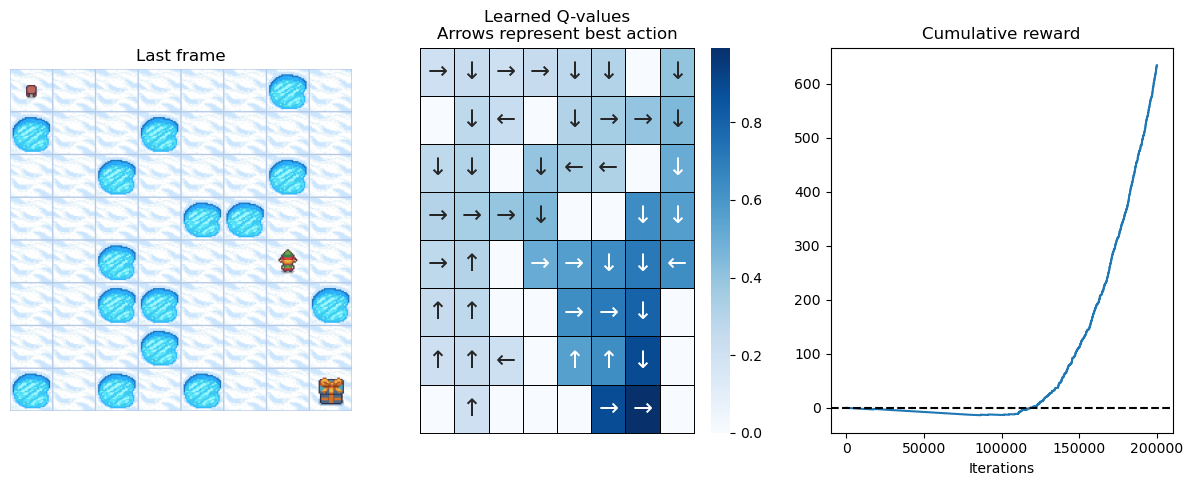

In [11]:
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from matplotlib import pyplot as plt


# Wrapper for the environment
# Overwrites step function
class RewardWrapper(gym.Wrapper):
    def __init__(self, env, r_hole):
        super().__init__(env)
        self.r_hole = r_hole

    def step(self, action):
        obs, r, terminated, truncated, info = self.env.step(action)
        # return predefined reward if in hole
        reward = self.r_hole if (terminated and r == 0) else r

        return obs, reward, terminated, truncated, info


# make environment with chosen options



# initialize base environment
base_env = gym.make('FrozenLake-v1', render_mode="rgb_array", desc=generate_random_map(size=8, seed=31414114), map_name="8x8", is_slippery=False)

# initialize test
test_name = "theta"
max_reward = -1000
best_learner = None

# Standard parameter
r_hole = -0.001
N = 10
balanced_wandering = 10
theta = 0.1
alpha = 0.5
gamma = 0.9

# Assing test values
if test_name == "theta":
    test_params = [0.01]#, 0.05, 0.1, 0.5]
elif test_name == "N":
    test_params = [0, 2, 4, 6 , 8, 10, 500]
elif test_name == "r_hole":
    test_params = [0, -0.01, -0.05, -0.1, -0.5, -1, -2]
elif test_name == "balanced_wandering":
    test_params = [0, 5, 10, 20, 50, 100]
else:
    test_params = []
    print("Please use a valid test name")

# optional plotting
# plt.figure(figsize=(10,10))

for param in test_params:
    # Assign test parameter
    if test_name == "theta":
        theta = param
    elif test_name == "N":
        N = param
    elif test_name == "r_hole":
        r_hole = param
    elif test_name == "balanced_wandering":
        balanced_wandering = param

    env = RewardWrapper(base_env, r_hole)
    learner = MBLearner(env)
    # run the learning
    q_values, reward = learner.learning(200000, N, balanced_wandering, theta, alpha, gamma)
    
    # optional plot
    # plt.plot(reward, label=str(param))

    print(param, "->", reward[-1] )

    # save highest reward and best learner
    if reward[-1] > max_reward:
        max_reward = reward[-1]
        best_learner = learner

    env.close()

# optional plot
#plt.title(f"Max cummulative reward for {test_name} was {max_reward}")
#plt.xlabel("iterations")
#plt.ylabel("cummulative rewards")
#plt.hlines(0, 0, 200000, linestyles="dashed", colors="black")
#plt.legend()
#plt.show()

best_learner.plot_q_values_map()



---
Please upload your submission via StudIP by 20:00 on May 22, 2024. If you encounter any issues with the upload process, please contact me in advance at laux@uni-bremen.de.

Your submission must include: 
- All the files you created or modified for your submission
- A small .txt file with the names and e-mail addresses of the contributing team members

